# Data Exploration


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

from src import process
from src import plot

# Update the combined-results-<i>-*.csv file if new data added to ./data/raw/
process.combine_raw_results()

# Load processed data frame
# If process.process_combined_results() is modified, then force_update=True is necessary
# to overwrite the existing processed results file
df = process.load_processed_results(force_update=True)

display(df.tail())

,id,is_pb,wpm,acc,raw_wpm,consistency,char_stats,mode,mode2,quote_length,...,iti_all,iti_session,time_since_last_new_sesh,combined_id,trial_type_id,z_wpm,z_acc,trial_num,trial_type_num,log_norm_wpm
2823,66bc8b6524029c3abd9291d8,0,38.6,96.04,38.6,67.94,386;0;0;0,time,120,-1,...,4.0,4.0,124000,29,1,1.448831,0.937945,2824,1069,9.562331
2824,66bc8be524029c3abd929639,0,35.8,94.72,35.8,65.57,358;0;0;0,time,120,-1,...,8.0,8.0,252000,29,1,0.858270,0.452701,2825,1070,8.249092
2825,66bdd94c91888c3435bd6e13,0,36.3,93.80,36.3,66.40,363;0;0;0,time,120,-1,...,85231.0,NaN,0,29,1,0.963727,0.114500,2826,1071,8.483599
2826,66bdd9cf91888c3435bd736f,0,34.9,92.39,34.9,70.78,349;0;0;0,time,120,-1,...,11.0,11.0,131000,29,1,0.668446,-0.403829,2827,1072,7.826980
2827,66bddab191888c3435bd7ca8,0,40.5,96.45,40.5,66.97,405;0;0;0,time,120,-1,...,106.0,106.0,0,29,1,1.849569,1.088665,2828,1073,10.453457


## Visualization of all trials


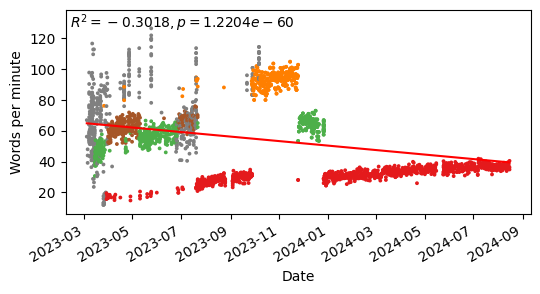

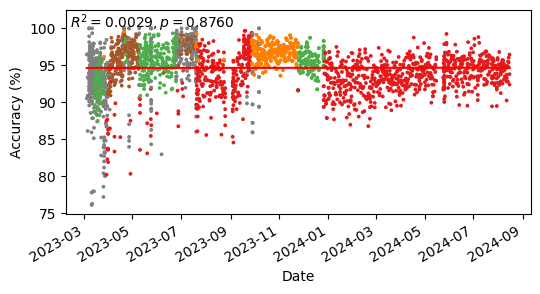

In [3]:
# WPM of all trials across all time
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "datetime", "wpm", plot_regression=True, s=3, n_colors=5)
plt.show()

# Acc of all trials across all time
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "datetime", "acc", plot_regression=True, s=3, n_colors=5)
plt.show()

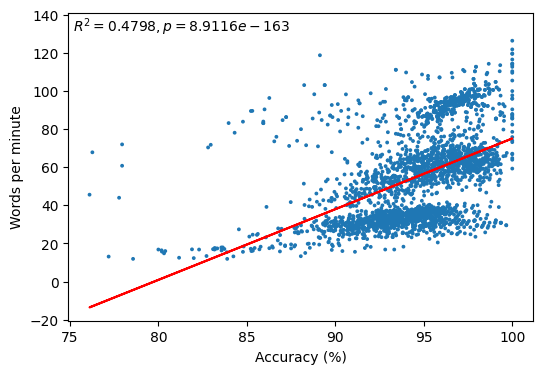

In [4]:
# Correlation between wpm and acc
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "acc", "wpm", plot_regression=True, s=3)
plt.show()

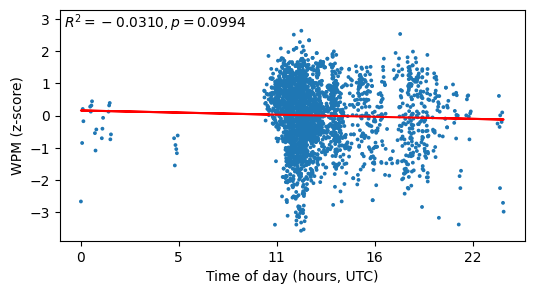

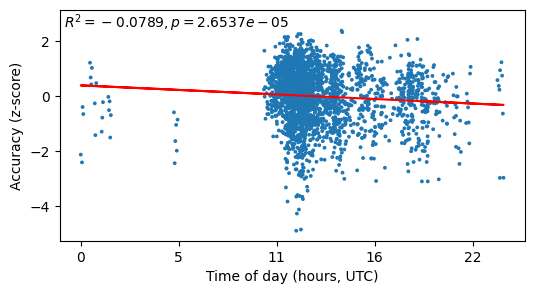

In [5]:
# Correlation between time_of_day_sec and z_wpm
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "time_of_day_sec", "z_wpm", plot_regression=True, s=3)
plt.show()

# Correlation between time_of_day_sec and z_acc
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "time_of_day_sec", "z_acc", plot_regression=True, s=3)
plt.show()

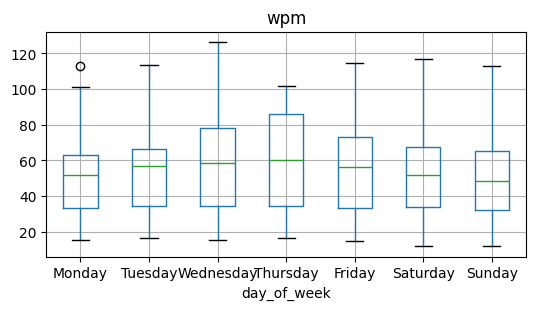

ANOVA: F-statistic = 7.27, p-value = 1.00e-07


In [6]:
feature = "wpm"
# Violin plot of wpm grouped by day of week
df.boxplot(column=feature, by="day_of_week", figsize=(6, 3))
plt.suptitle("")
plt.show()

# Compare the mean wpm for each day of the week with a 1-way ANOVA
groups = df.groupby("day_of_week", observed=True)[feature].apply(list)
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.2e}")

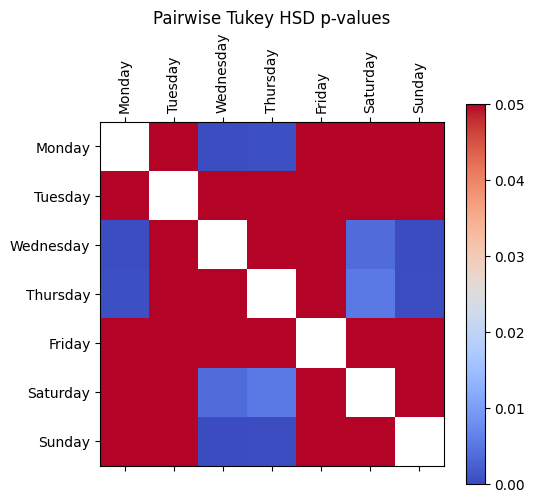

group1,group2,meandiff,p-adj,lower,upper,reject
Friday,Monday,-4.2248,0.1682,-9.2584,0.8088,False
Friday,Saturday,-3.0524,0.5312,-7.9875,1.8828,False
Friday,Sunday,-4.6005,0.0962,-9.6099,0.4089,False
Friday,Thursday,3.2144,0.5038,-1.87,8.2988,False
Friday,Tuesday,-0.5813,0.9998,-5.4436,4.2811,False
Friday,Wednesday,2.9333,0.5285,-1.7992,7.6659,False
Monday,Saturday,1.1725,0.9934,-3.8671,6.2121,False
Monday,Sunday,-0.3757,1.0,-5.488,4.7367,False
Monday,Thursday,7.4392,0.0005,2.2533,12.6251,True
Monday,Tuesday,3.6436,0.3158,-1.3248,8.6119,False


In [7]:
# Plot a matrix of pairwise p-values from the tukey result

# Perform the Tukey HSD test
tukey = pairwise_tukeyhsd(df["wpm"], df["day_of_week"], alpha=0.05)

# Create matrix of all pairwise p-values
groups = tukey.groupsunique
matrix_size = len(groups)
pvalue_matrix = np.full((matrix_size, matrix_size), np.nan)
group_indices = {group: index for index, group in enumerate(groups)}
# Fill the matrix
for result in tukey.summary().data[1:]:  # Skip the header row
    group1, group2 = result[0], result[1]
    pvalue = result[3]
    idx1, idx2 = group_indices[group1], group_indices[group2]
    pvalue_matrix[idx1, idx2] = pvalue
    pvalue_matrix[idx2, idx1] = pvalue
sorted_indices = [
    group_indices[day]
    for day in [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
]
pvalue_matrix = pvalue_matrix[sorted_indices, :][:, sorted_indices]
fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(pvalue_matrix, cmap="coolwarm")
fig.colorbar(cax)
ax.set_xticks(np.arange(matrix_size))
ax.set_yticks(np.arange(matrix_size))
ax.set_xticklabels(groups[sorted_indices], rotation=90)
ax.set_yticklabels(groups[sorted_indices], rotation=0)
plt.title("Pairwise Tukey HSD p-values")
plt.tight_layout()
cax.set_clim(0, 0.05)
plt.show()

tukey.summary()

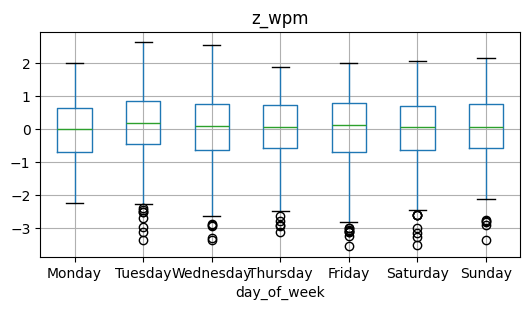

ANOVA: F-statistic = 1.59, p-value = 1.45e-01


In [8]:
feature = "z_wpm"
# Violin plot of wpm grouped by day of week, sorted by Monday to Sunday
df.boxplot(column=feature, by="day_of_week", figsize=(6, 3))
plt.suptitle("")
plt.show()

# Compare the mean wpm for each day of the week with a 1-way ANOVA
groups = df.groupby("day_of_week", observed=True)[feature].apply(list)
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.2e}")

## Analysis Within and across sessions


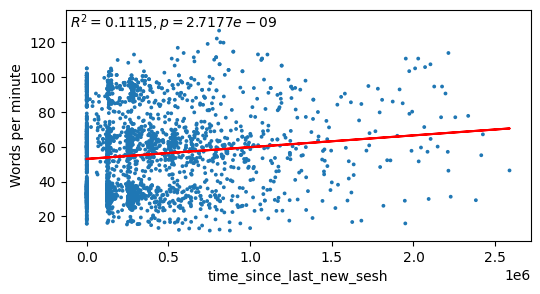

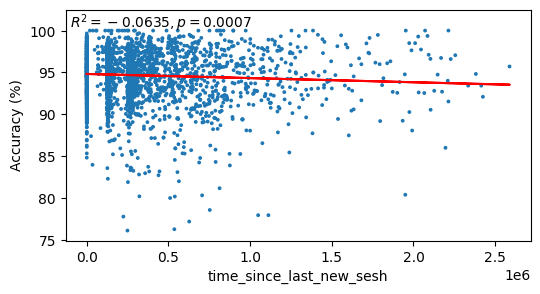

In [9]:
# Correlation between time_since_last_new_sesh and wpm
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(
    df, "time_since_last_new_sesh", "wpm", plot_regression=True, s=3
)  # datetime
plt.show()

# Correlation between time_since_last_new_sesh and acc
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(
    df, "time_since_last_new_sesh", "acc", plot_regression=True, s=3
)  # datetime
plt.show()

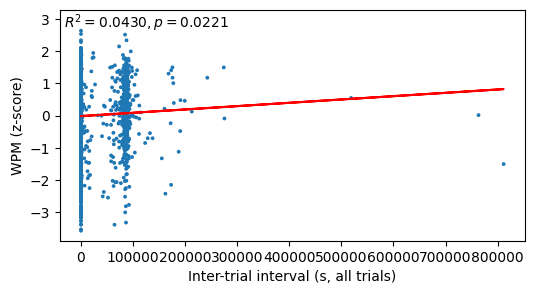

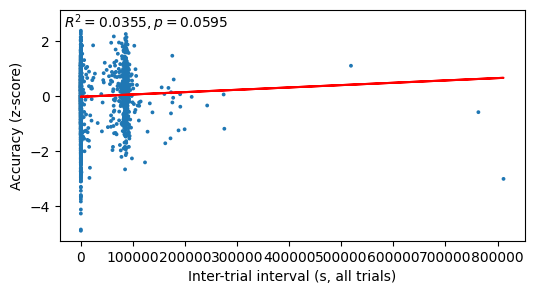

In [10]:
# Z-scored WPM as a function of all inter-trial intervals (ITI)
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_all", "z_wpm", plot_regression=True, s=3)
plt.show()

# Z-scored Acc as a function of all inter-trial intervals (ITI)
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_all", "z_acc", plot_regression=True, s=3)
plt.show()

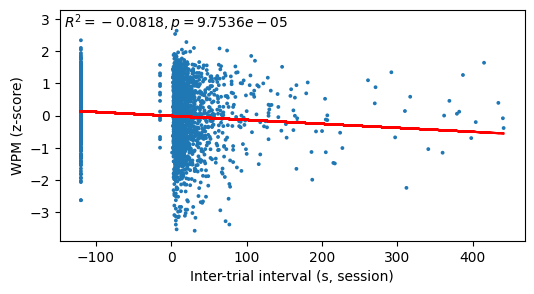

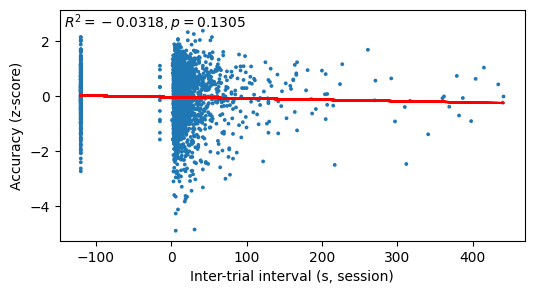

In [11]:
# Z-scored WPM as a function of inter-trial interval (ITI) within a session
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_session", "z_wpm", plot_regression=True, s=3)
plt.show()

# Z-scored Acc as a function of inter-trial interval (ITI) within a session
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_session", "z_acc", plot_regression=True, s=3)
plt.show()

## Performance autocorrelation


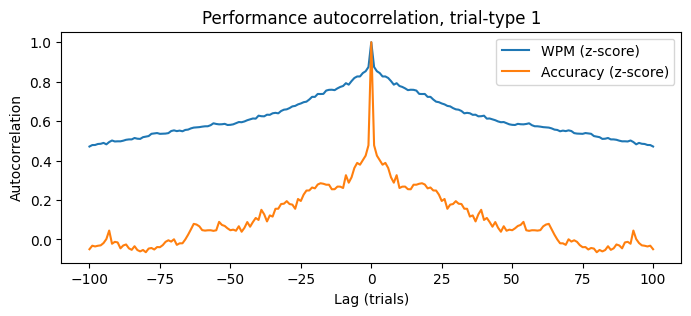

In [12]:
# Trial WPM/Acc autocorrelations for one trial type
fig = plt.figure(figsize=(8, 3))
ax = plot.performance_autocorrelation(df, trial_type_id=1)
plt.show()

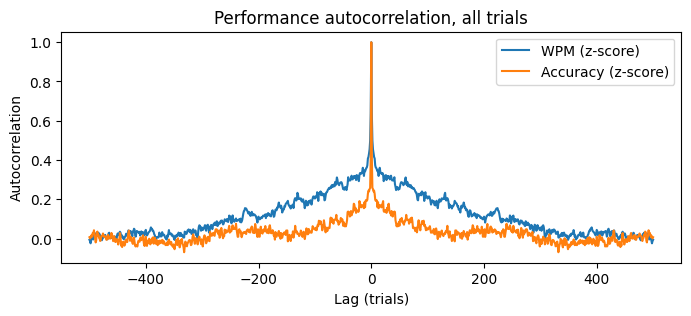

In [13]:
# Trial WPM/Acc autocorrelations for all trials
n_lags = 500
fig = plt.figure(figsize=(8, 3))
ax = plot.performance_autocorrelation(df, trial_type_id=None, n_lags=n_lags)
plt.show()

## Performance split by trial properties


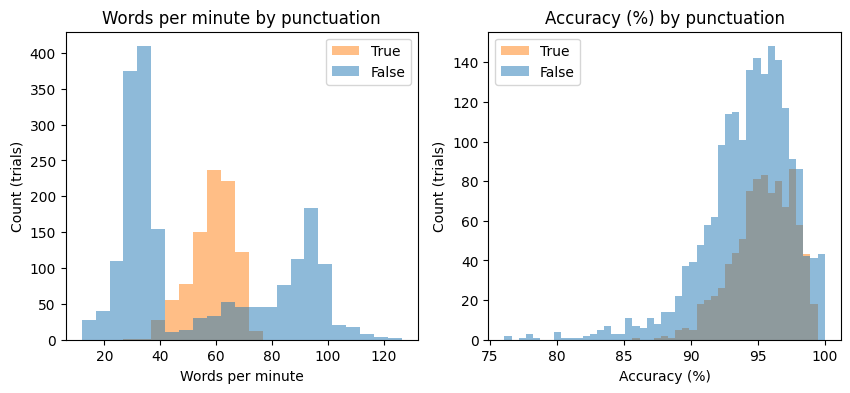

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot.histogram_by_type(df, "wpm", "punctuation", ax=ax[0])
plot.histogram_by_type(df, "acc", "punctuation", ax=ax[1])
plt.show()

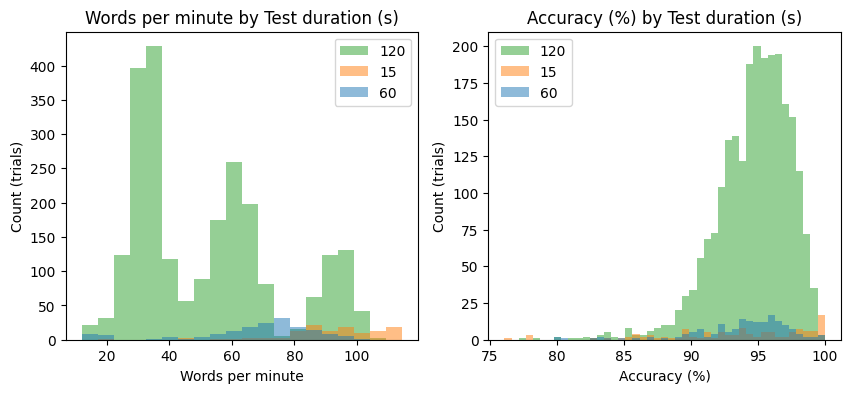

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot.histogram_by_type(df, "wpm", "test_duration", ax=ax[0])
plot.histogram_by_type(df, "acc", "test_duration", ax=ax[1])
plt.show()